In [2]:
import random
from math import sqrt, exp, pow, sin
#importation de problem 
from jmetal.core.problem import BinaryProblem
from jmetal.core.solution import BinarySolution
from jmetal.problem import OneMax
from random import randint 

from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.algorithm.multiobjective.spea2 import SPEA2
from jmetal.operator import BitFlipMutation, SPXCrossover
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.lab.visualization.plotting import Plot
from jmetal.util.solution import *
from jmetal.core.quality_indicator import *
import time as tm
from jmetal.util.observer import ProgressBarObserver
import pandas as pd

In [3]:
class OneZeroMax(BinaryProblem):
    def __init__(self, number_of_bits):
        super(OneZeroMax, self).__init__()
        self.number_of_bits = number_of_bits
        self.number_of_objectives = 2
        self.number_of_variables = 1
        self.number_of_constraints = 0
        self.obj_directions = [self.MINIMIZE,self.MINIMIZE]
        self.obj_labels = ['Ones','Zero']

    def number_of_variables(self) -> int:
        return 1

    def number_of_objectives(self) -> int:
        return 2

    def number_of_constraints(self) -> int:
        return 0 

    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        counter_of_ones = 0
        counter_of_zeroes = 0
        for bits in solution.variables[0]:
            if bits:
                counter_of_ones += 1
            else:
                counter_of_zeroes += 1

        solution.objectives[0] = -1.0 * counter_of_ones
        solution.objectives[1] = -1.0 * counter_of_zeroes

        return solution

    def create_solution(self):
        new_solution = BinarySolution(number_of_variables=1, number_of_objectives=2)
        new_solution.variables[0] = \
        [True if randint(0, 1) == 0 else False for _ in range(self.number_of_bits)]
        return new_solution

    def name(self) -> str:
        return 'OneZeroMax'

In [4]:
def create_nsgaii_algorithm(problem, max_evaluations=25000):
    return NSGAII(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=BitFlipMutation(1.0 / problem.number_of_bits),
        crossover=SPXCrossover(0.9),
        termination_criterion=StoppingByEvaluations(max_evaluations)
    )

In [5]:
def create_ibea_algorithm(problem, max_evaluations=25000):
    return IBEA(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=BitFlipMutation(1.0 / problem.number_of_bits),
        crossover=SPXCrossover(0.9),
        termination_criterion=StoppingByEvaluations(max_evaluations),
        kappa = 0.05
    )

In [6]:
def create_spea2_algorithm(problem, max_evaluations=25000):
    return SPEA2(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=BitFlipMutation(1.0 / problem.number_of_bits),
        crossover=SPXCrossover(0.9),
        termination_criterion=StoppingByEvaluations(max_evaluations),
    )

In [7]:
def plot_pareto_front(solutions, problem):
    front = get_non_dominated_solutions(solutions)
    plot_front = Plot('Pareto front approximation', axis_labels=['ones', 'zeros'])
    plot_front.plot(front, label=problem.name())
    

In [8]:
def save_results_to_file(algorithm, front):
    timestamp = tm.strftime("%Y-%m-%d-%H-%M-%S", tm.localtime())
    print_function_values_to_file(front, "FUN." + algorithm.label + "." + timestamp)
    print_variables_to_file(front, "VAR." + algorithm.label + "." + timestamp)

In [9]:
def metric_calculation(solutions):
    indicator = HyperVolume([0, 0])
    objectives = []
    for solution in solutions:
        objectives.append(solution.objectives)
        hv = round(indicator.compute(objectives), 0)
    print(f"Hypervolume: ", str(hv))
    return hv

In [10]:
def run_algorithm(create_algorithm: callable, algo_params: dict, number_of_bits=256, max_evaluations=25000):
                    
    """
    Runs a genetic algorithm to solve the OneZeroMax problem.

    Args:
        number_of_bits (int): The size of the binary string to optimize.
        max_evaluations (int): The maximum number of evaluations.
    """

    problem = OneZeroMax(number_of_bits)
    algorithm = create_algorithm(problem, max_evaluations, **algo_params)

    # On le fait tourner
    algorithm.run()
    solutions = algorithm.get_result()

    plot_pareto_front(solutions, problem)
    front = get_non_dominated_solutions(solutions)
    save_results_to_file(algorithm, front)
    metric = metric_calculation(solutions)

    progress_bar = ProgressBarObserver(max=max_evaluations)
    algorithm.observable.register(progress_bar)

    print(f"Algorithm: {algorithm.get_name()}")
    print(f"Problem: {problem.name()}")
    print(f"Computing time: {algorithm.total_computing_time}")

    return metric



In [11]:
def train(problem_function : callable, problem_function_params : dict, nb_runs : int = 20):
  """
  Trains a problem function by running it multiple times and collecting fitness results and running times.

  Parameters:
  problem_function (callable): The problem function to be trained.
  problem_function_params (dict): The parameters to be passed to the problem function.
  nb_runs (int, optional): The number of times to run the problem function. Defaults to 20.

  Returns:
  pd.Series: A series containing the fitness results of each run.
  pd.Series: A series containing the running times of each run.
  """
  fitnesses = []
  running_times = []

  for _ in range(nb_runs):
    start_time = tm.time()
    fitness_result = problem_function(**problem_function_params)
    execution_time = tm.time() - start_time

    fitnesses.append(fitness_result)
    running_times.append(execution_time)

  return pd.Series(fitnesses), pd.Series(running_times)

[2024-03-26 10:11:56,955] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:56,960] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:56,962] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:56,962] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2024-03-26 10:11:57,055] [jmetal.core.algorithm] [DEBUG] Finished!


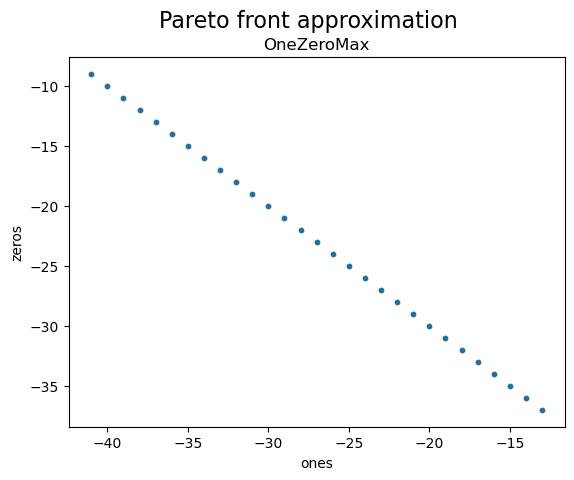

[2024-03-26 10:11:57,133] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,134] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,141] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:57,143] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:57,143] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:57,143] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2024-03-26 10:11:57,223] [jmetal.core.algorithm] [DEBUG] Finished!


Hypervolume:  1111.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.0999290943145752


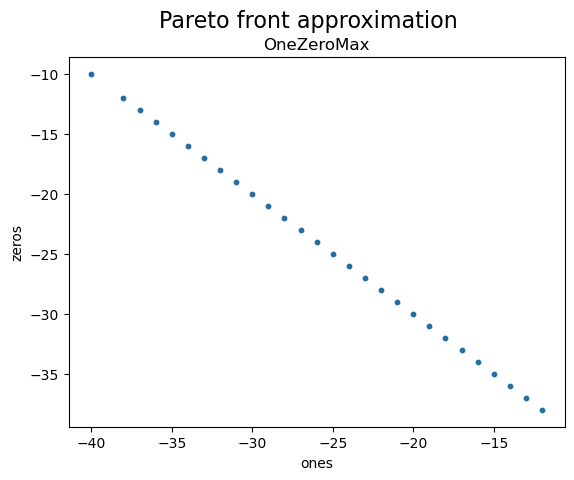

[2024-03-26 10:11:57,280] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,280] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,289] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:57,290] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:57,291] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:57,291] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1113.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08180928230285645


[2024-03-26 10:11:57,371] [jmetal.core.algorithm] [DEBUG] Finished!


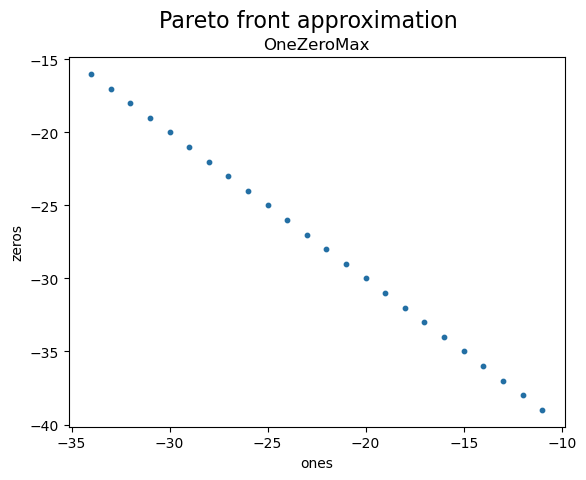

[2024-03-26 10:11:57,430] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,431] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,439] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:57,440] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:57,441] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:57,441] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1050.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08309507369995117


[2024-03-26 10:11:57,551] [jmetal.core.algorithm] [DEBUG] Finished!


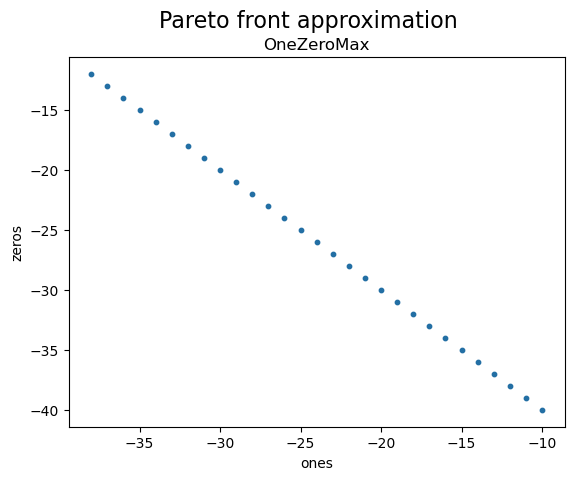

[2024-03-26 10:11:57,610] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,611] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,618] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:57,620] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:57,620] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:57,620] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1114.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.11276912689208984


[2024-03-26 10:11:57,701] [jmetal.core.algorithm] [DEBUG] Finished!


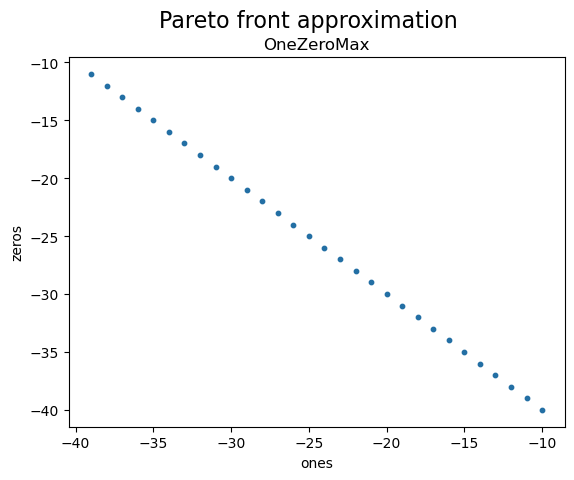

[2024-03-26 10:11:57,760] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,761] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,769] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:57,771] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:57,771] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:57,771] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1125.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08270692825317383


[2024-03-26 10:11:57,850] [jmetal.core.algorithm] [DEBUG] Finished!


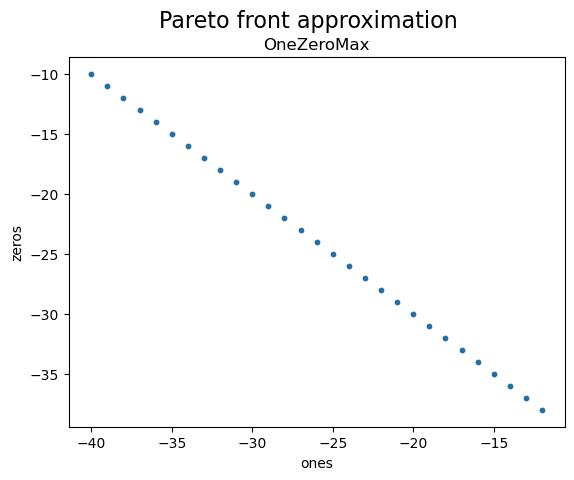

[2024-03-26 10:11:57,914] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,915] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-57
[2024-03-26 10:11:57,924] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:57,926] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:57,926] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:57,927] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1114.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08166193962097168


[2024-03-26 10:11:58,032] [jmetal.core.algorithm] [DEBUG] Finished!


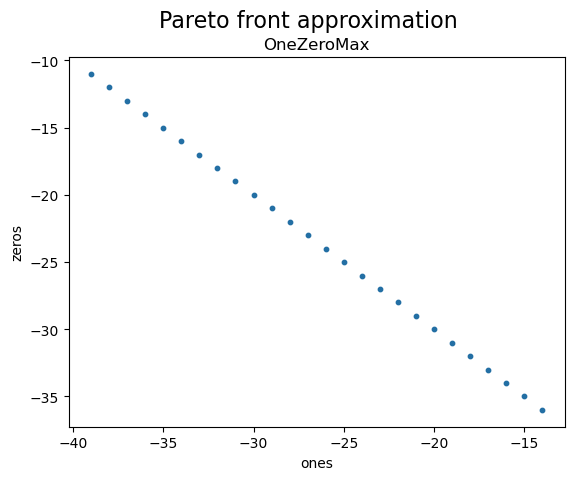

[2024-03-26 10:11:58,093] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,094] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,103] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:58,105] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:58,106] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:58,106] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1079.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.10826683044433594


[2024-03-26 10:11:58,187] [jmetal.core.algorithm] [DEBUG] Finished!


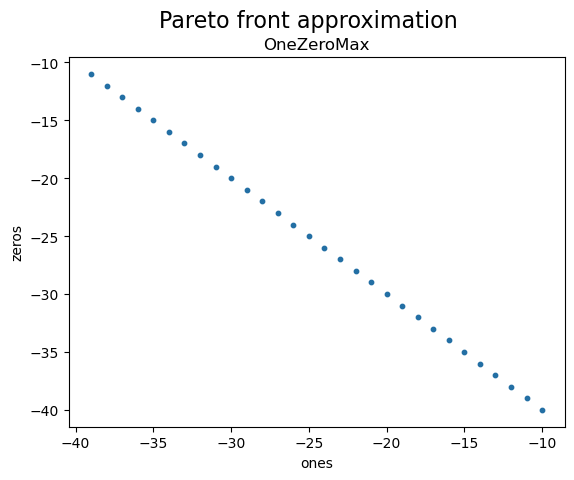

[2024-03-26 10:11:58,250] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,251] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,313] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:58,315] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:58,316] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:58,316] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2024-03-26 10:11:58,395] [jmetal.core.algorithm] [DEBUG] Finished!


Hypervolume:  1125.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08374881744384766


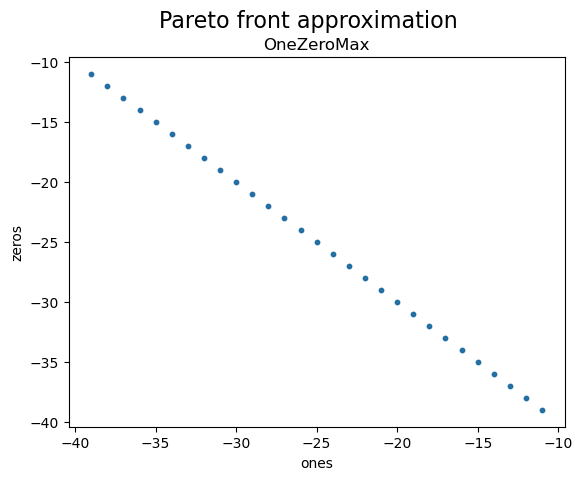

[2024-03-26 10:11:58,455] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,456] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,465] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:58,467] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:58,468] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:58,468] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1115.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08294820785522461


[2024-03-26 10:11:58,566] [jmetal.core.algorithm] [DEBUG] Finished!


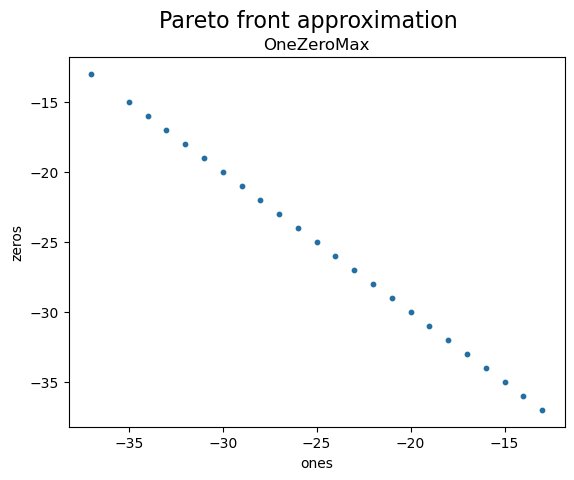

[2024-03-26 10:11:58,635] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,636] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,644] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:58,646] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:58,646] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:58,646] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1068.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.10873174667358398


[2024-03-26 10:11:58,726] [jmetal.core.algorithm] [DEBUG] Finished!


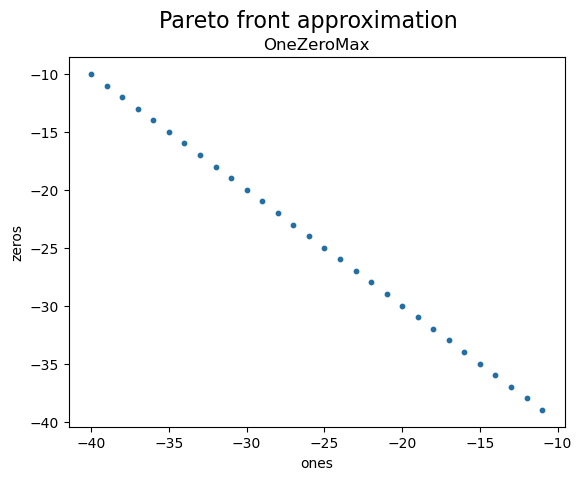

[2024-03-26 10:11:58,787] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,788] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,797] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:58,798] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:58,799] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:58,799] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1125.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08290290832519531


[2024-03-26 10:11:58,879] [jmetal.core.algorithm] [DEBUG] Finished!


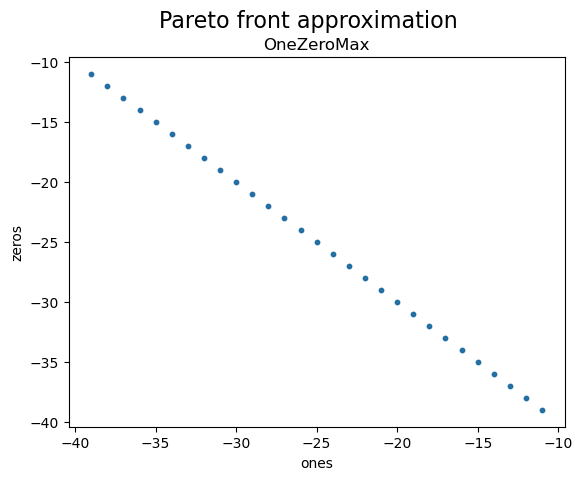

[2024-03-26 10:11:58,942] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,942] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-58
[2024-03-26 10:11:58,952] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:58,953] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:58,955] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:58,955] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1115.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08299994468688965


[2024-03-26 10:11:59,060] [jmetal.core.algorithm] [DEBUG] Finished!


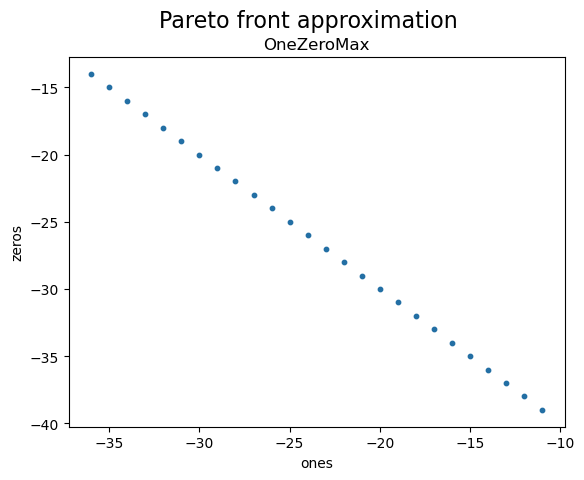

[2024-03-26 10:11:59,123] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,124] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,132] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:59,134] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:59,134] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:59,135] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1079.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.10964584350585938


[2024-03-26 10:11:59,227] [jmetal.core.algorithm] [DEBUG] Finished!


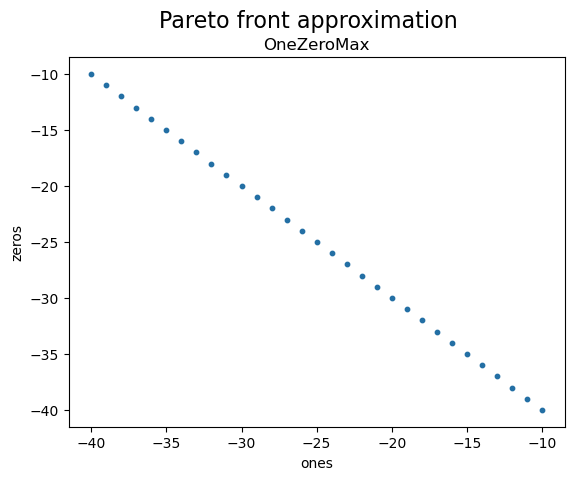

[2024-03-26 10:11:59,288] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,289] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,298] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:59,300] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:59,300] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:59,301] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1135.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.09493088722229004


[2024-03-26 10:11:59,382] [jmetal.core.algorithm] [DEBUG] Finished!


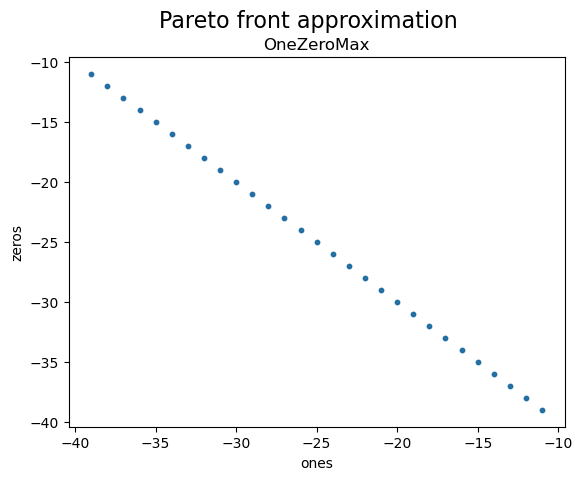

[2024-03-26 10:11:59,468] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,470] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,480] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:59,484] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:59,485] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:59,485] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1115.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08447575569152832


[2024-03-26 10:11:59,564] [jmetal.core.algorithm] [DEBUG] Finished!


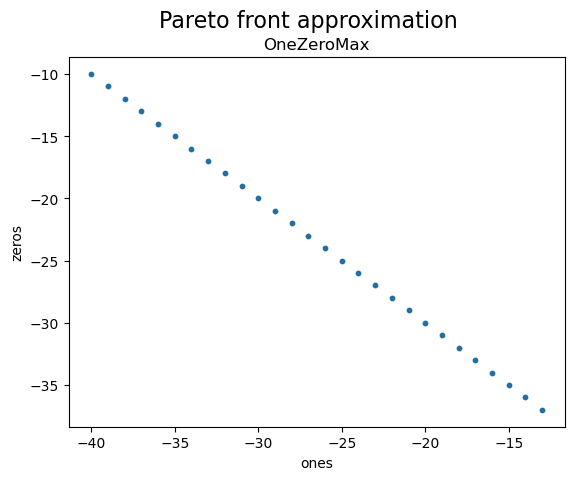

[2024-03-26 10:11:59,625] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,626] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,635] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:59,637] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:59,637] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:59,638] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1102.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08484673500061035


[2024-03-26 10:11:59,720] [jmetal.core.algorithm] [DEBUG] Finished!


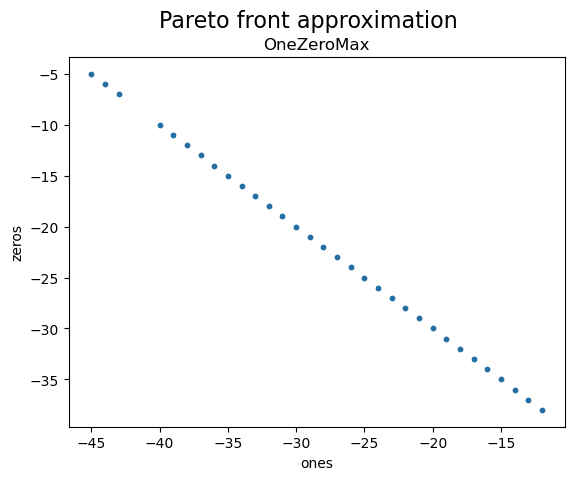

[2024-03-26 10:11:59,783] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,784] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,792] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:59,794] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:59,794] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:59,794] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1146.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08517718315124512


[2024-03-26 10:11:59,910] [jmetal.core.algorithm] [DEBUG] Finished!


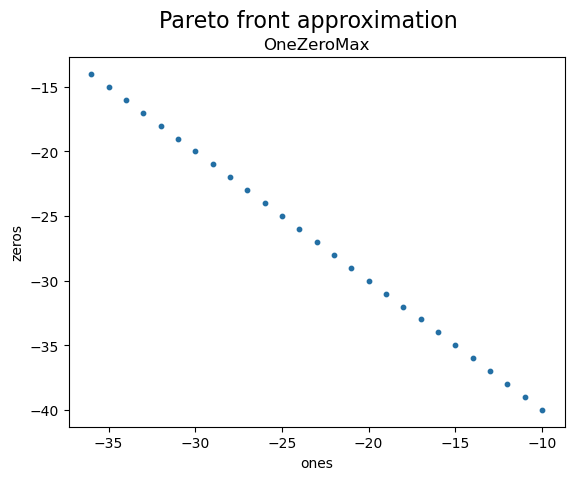

[2024-03-26 10:11:59,967] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,968] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-11-59
[2024-03-26 10:11:59,978] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:11:59,980] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:11:59,980] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:11:59,981] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1089.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.11934614181518555


[2024-03-26 10:12:00,061] [jmetal.core.algorithm] [DEBUG] Finished!


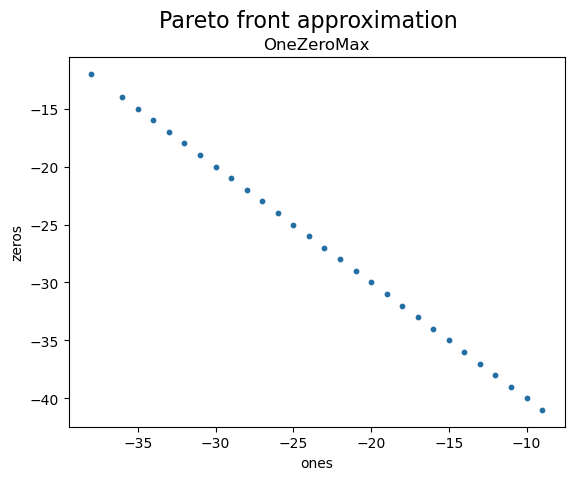

[2024-03-26 10:12:00,122] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-12-00
[2024-03-26 10:12:00,122] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-12-00
[2024-03-26 10:12:00,131] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-03-26 10:12:00,133] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-03-26 10:12:00,133] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-03-26 10:12:00,133] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Hypervolume:  1122.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08366107940673828


[2024-03-26 10:12:00,217] [jmetal.core.algorithm] [DEBUG] Finished!


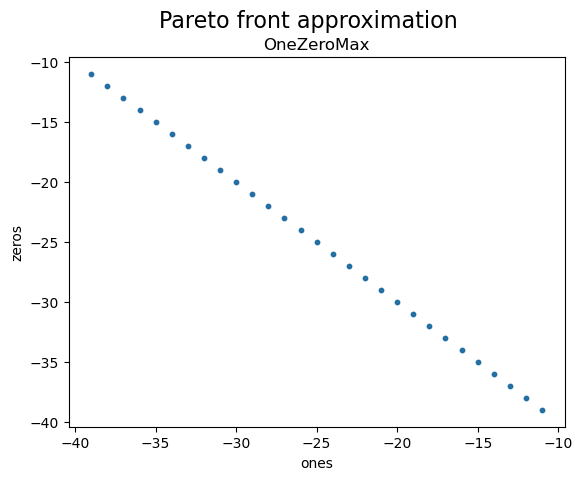

[2024-03-26 10:12:00,298] [jmetal.util.solution] [INFO] Output file (function values): FUN.NSGAII.OneZeroMax.2024-03-26-10-12-00
[2024-03-26 10:12:00,301] [jmetal.util.solution] [INFO] Output file (variables): VAR.NSGAII.OneZeroMax.2024-03-26-10-12-00


Hypervolume:  1115.0
Algorithm: NSGAII
Problem: OneZeroMax
Computing time: 0.08658385276794434


In [12]:
Problem_params = {
      "number_of_bits": 50,
      "max_evaluations": 1000,
      "create_algorithm": create_nsgaii_algorithm,
      "algo_params": {}
    }
  

fitnesses, running_times = train(problem_function=run_algorithm, problem_function_params=Problem_params, nb_runs=20)
                              

In [ ]:
Problem_params = {
      "number_of_bits": 50,
      "max_evaluations": 1000,
      "create_algorithm": create_ibea_algorithm,
      "algo_params": {}
    }
  

fitnesses, running_times = train(problem_function=run_algorithm, problem_function_params=Problem_params, nb_runs=20)
                

In [ ]:
Problem_params = {
      "number_of_bits": 10,
      "max_evaluations": 500,
      "create_algorithm": create_spea2_algorithm,
      "algo_params": {}
    }

fitnesses, running_times = train(problem_function=run_algorithm, problem_function_params=Problem_params, nb_runs=20)

In [13]:
df = pd.concat([fitnesses, running_times], axis=1)
print(df)

         0         1
0   1111.0  0.186156
1   1113.0  0.147377
2   1050.0  0.150244
3   1114.0  0.179420
4   1125.0  0.150752
5   1114.0  0.155350
6   1079.0  0.179117
7   1125.0  0.209247
8   1115.0  0.152459
9   1068.0  0.178726
10  1125.0  0.152649
11  1115.0  0.155145
12  1079.0  0.180720
13  1135.0  0.165656
14  1115.0  0.181713
15  1102.0  0.155533
16  1146.0  0.156559
17  1089.0  0.186347
18  1122.0  0.152796
19  1115.0  0.182857


> Pour la partie sélection d'attributs
* premier objectif: le meilleur target
* deuxième objectif: le meilleur target avec le moins d'attributs possibles: donc minimiser le nombre de 1
  * donc faire une nouvelle fonction evaluate

Du coup utiliser les nouveaux algorithmes et remplacer les algos en place


Pour cette partie on doit faire une moyenne et un écart type sur les hypervolumes, on veut les plus grandes valeurs